In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from common.data_frame_columns import PM10, PM2_5, PM1
from common.date_time_helper import convert_to_datetime
from common.endpoints_urls import endpoints_config
from common.working_dataset_config import working_datetime, test_date_time_strings
from data_management.data_crawler import DataManager
from data_management.data_reshaper import reshape_data, prepare_dataset, flatten_data
from data_management.labeled_data_generator import LabeledDataGenerator, DataLabel
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [2]:
date_strings = ['01.01.2023 00:00', '31.12.2023 23:59']
test_dates_string = ['01.01.2024 00:00', '30.04.2024 23:59']

training_dates = [convert_to_datetime(date_strings[0]), convert_to_datetime(date_strings[1])]
test_dates = [convert_to_datetime(test_dates_string[0]), convert_to_datetime(test_dates_string[1])]

datas = DataManager(True).get_all_endpoints_data(endpoints_config, update=False)

column = PM10
L = LabeledDataGenerator(column)

test_data = L.generate_labeled_data(datas[:1], test_dates[0], test_dates[1], 40)
single_data = L.generate_labeled_data(datas[:1], training_dates[0], training_dates[1], 40)
multi_data = L.generate_labeled_data(datas, training_dates[0], training_dates[1], 40)

Loading station data: Gronie  https://datahub.ki.agh.edu.pl/api/endpoints/70/data/
    # Minimal data: 2022-07-13 23:38:02+00:00
    # Maximal data: 2024-05-10 16:16:39+00:00
Loading station data: Urząd Gminy  https://datahub.ki.agh.edu.pl/api/endpoints/71/data/
    # Minimal data: 2023-10-28 07:17:18+00:00
    # Maximal data: 2024-05-10 16:15:37+00:00
Loading station data: Młynne  https://datahub.ki.agh.edu.pl/api/endpoints/72/data/
    # Minimal data: 2022-02-12 21:11:18+00:00
    # Maximal data: 2024-05-10 16:15:59+00:00
Loading station data: Sucharskiego  https://datahub.ki.agh.edu.pl/api/endpoints/73/data/
    # Minimal data: 2021-10-07 19:41:43+00:00
    # Maximal data: 2024-05-10 16:19:11+00:00
Loading station data: Twardowskiego  https://datahub.ki.agh.edu.pl/api/endpoints/74/data/
    # Minimal data: 2021-10-07 20:59:56+00:00
    # Maximal data: 2024-05-10 16:20:04+00:00
Loading station data: Konopnickiej  https://datahub.ki.agh.edu.pl/api/endpoints/75/data/
    # Minimal data

In [11]:
class MyMLPClassifier:
    def __init__(self, kernel=None):
        self.xdxd = MLPClassifier(hidden_layer_sizes=(500,100,50), random_state=1, max_iter=1000, solver='sgd')

    def fit_data(self, labeled_data, column):
        X, y = prepare_dataset(labeled_data, column)
        X = flatten_data(X)
        self.xdxd.fit(X, y)

    def test_accuracy(self, labeled_data, column):
        X_set, y_set = prepare_dataset(labeled_data, column)
        X_set = flatten_data(X_set)
        predicted = self.xdxd.predict(X_set)
        accuracy = accuracy_score(y_set, predicted)
        precision = precision_score(y_set, predicted, average='weighted')
        recall = recall_score(y_set, predicted, average='weighted')
        f1 = f1_score(y_set, predicted, average='weighted', zero_division=np.nan)

        return accuracy, precision, recall, f1

In [12]:
from matplotlib import pyplot as plt

kernels = ['linear', 
           # 'poly', 'rbf', 'sigmoid'
           ]
config_list = [
    {
        'name': 'mlp_SDSC',
        'columns': [PM10],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'mlp_SDMC',
        'columns': [PM10, PM1, PM2_5],
        'training_datas': single_data,
        'test_datas': test_data
    },
    {
        'name': 'mlp_MDSC',
        'columns': [PM10],
        'training_datas': multi_data,
        'test_datas': test_data
    },
    {
        'name': 'mlp_MDMC',
        'columns': [PM10, PM1, PM2_5],
        'training_datas': multi_data,
        'test_datas': test_data
    }
]
final_result = []
for config in config_list:
    acc = []
    prec = []
    rec = []
    f1_s = []
    for kernel in kernels:
        knn = MyMLPClassifier(kernel)
        knn.fit_data(config['training_datas'], config['columns'])
        accuracy, precision, recall, f1 = knn.test_accuracy(config['test_datas'], config['columns'])
        acc.append(accuracy)
        prec.append(precision)
        rec.append(recall)
        f1_s.append(f1)
        
        print({'name': config['name'], 'kernel': kernel, 'accuracy': accuracy, 'precision': precision, 'recall': recall,
               'f1': f1})

    final_result.append({'name': config['name'], 
                         'acc': acc,
                         'prec': prec,
                         'recall': rec,
                         'f1': f1_s, })


{'name': 'mlp_SDSC', 'kernel': 'linear', 'accuracy': 0.7128712871287128, 'precision': 0.7326332633263326, 'recall': 0.7128712871287128, 'f1': 0.7133298464981634}
{'name': 'mlp_SDMC', 'kernel': 'linear', 'accuracy': 0.8613861386138614, 'precision': 0.8567106710671067, 'recall': 0.8613861386138614, 'f1': 0.8508934927106157}
{'name': 'mlp_MDSC', 'kernel': 'linear', 'accuracy': 0.7722772277227723, 'precision': 0.7806380638063806, 'recall': 0.7722772277227723, 'f1': 0.7527865601686219}
{'name': 'mlp_MDMC', 'kernel': 'linear', 'accuracy': 0.9108910891089109, 'precision': 0.8679867986798679, 'recall': 0.9108910891089109, 'f1': 0.8867792661619103}


/media/kkoz34/HDD_kkoz34/Magisterka/Magisterka/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


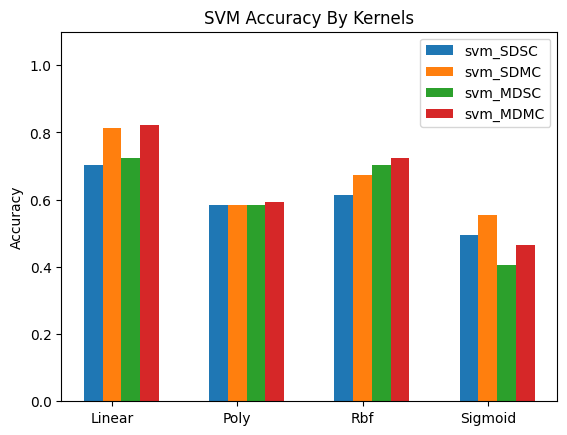

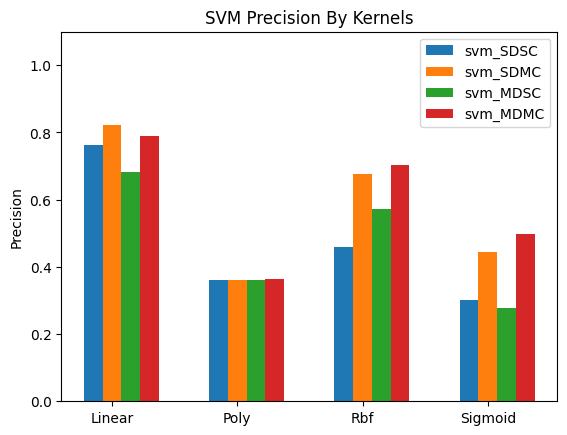

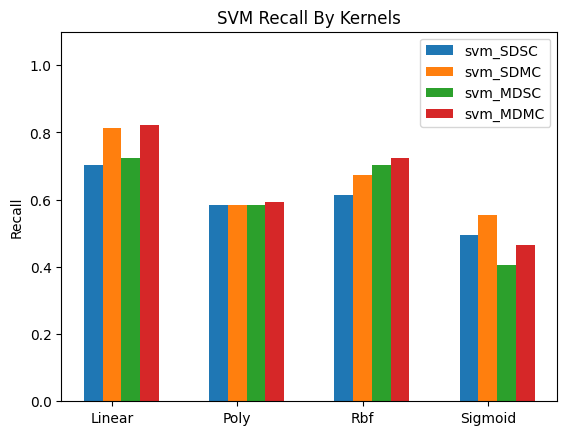

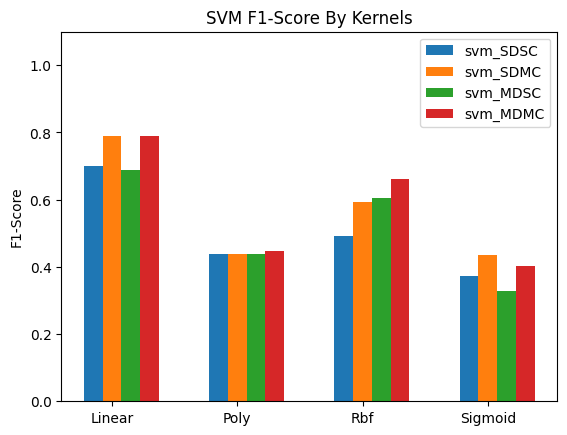

In [42]:
x_labels = [kernel.title() for kernel in kernels]
x = np.arange(len(x_labels))
width = 0.15 
multiplier = 0
fig, ax = plt.subplots()
for result in final_result:
    offset = width * multiplier
    rects = ax.bar(x + offset, result['acc'], width, label=result['name'])
    # ax.bar_label(rects, padding=4)
    multiplier += 1
    
ax.set_ylabel('Accuracy')
ax.set_title('SVM Accuracy By Kernels')
ax.set_xticks(x + width, x_labels)
ax.legend(loc='upper right', )
ax.set_ylim(0, 1.1)
plt.show()


x = np.arange(len(x_labels))
multiplier = 0
fig, ax = plt.subplots()
for result in final_result:
    offset = width * multiplier
    rects = ax.bar(x + offset, result['prec'], width, label=result['name'])
    # ax.bar_label(rects, padding=4)
    multiplier += 1
    
ax.set_ylabel('Precision')
ax.set_title('SVM Precision By Kernels')
ax.set_xticks(x + width, x_labels)
ax.legend(loc='upper right', )
ax.set_ylim(0, 1.1)
plt.show()


x = np.arange(len(x_labels))
multiplier = 0
fig, ax = plt.subplots()
for result in final_result:
    offset = width * multiplier
    rects = ax.bar(x + offset, result['recall'], width, label=result['name'])
    # ax.bar_label(rects, padding=4)
    multiplier += 1
    
ax.set_ylabel('Recall')
ax.set_title('SVM Recall By Kernels')
ax.set_xticks(x + width, x_labels)
ax.legend(loc='upper right', )
ax.set_ylim(0, 1.1)
plt.show()

x = np.arange(len(x_labels))
multiplier = 0
fig, ax = plt.subplots()
for result in final_result:
    offset = width * multiplier
    rects = ax.bar(x + offset, result['f1'], width, label=result['name'])
    multiplier += 1
    
ax.set_ylabel('F1-Score')
ax.set_title('SVM F1-Score By Kernels')
ax.set_xticks(x + width, x_labels)
ax.legend(loc='upper right')
ax.set_ylim(0, 1.1)
plt.show()

In [48]:
for result in final_result:
    for key, value in result.items():
        print(f'{key} : {value}')
    print()

name : svm_SDSC
acc : [0.7029702970297029, 0.5841584158415841, 0.6138613861386139, 0.49504950495049505]
prec : [0.762245961438249, 0.36014851485148514, 0.4589587991057171, 0.30036711536322175]
recall : [0.7029702970297029, 0.5841584158415841, 0.6138613861386139, 0.49504950495049505]
f1 : [0.6993152953548993, 0.4389558955895589, 0.49136648358713425, 0.37388354220037384]

name : svm_SDMC
acc : [0.8118811881188119, 0.5841584158415841, 0.6732673267326733, 0.5544554455445545]
prec : [0.8219107625048219, 0.36014851485148514, 0.675646634430885, 0.4433088470137337]
recall : [0.8118811881188119, 0.5841584158415841, 0.6732673267326733, 0.5544554455445545]
f1 : [0.7883684748565354, 0.4389558955895589, 0.594132774622, 0.4341887249949485]

name : svm_MDSC
acc : [0.7227722772277227, 0.5841584158415841, 0.7029702970297029, 0.40594059405940597]
prec : [0.6824937438798825, 0.36014851485148514, 0.5714285714285714, 0.2786396900559622]
recall : [0.7227722772277227, 0.5841584158415841, 0.7029702970297029, 

In [ ]:
'''
name : svm_SDSC
acc : [0.7029702970297029, 0.5841584158415841, 0.6138613861386139, 0.49504950495049505]
prec : [0.762245961438249, 0.36014851485148514, 0.4589587991057171, 0.30036711536322175]
recall : [0.7029702970297029, 0.5841584158415841, 0.6138613861386139, 0.49504950495049505]
f1 : [0.6993152953548993, 0.4389558955895589, 0.49136648358713425, 0.37388354220037384]

name : svm_SDMC
acc : [0.8118811881188119, 0.5841584158415841, 0.6732673267326733, 0.5544554455445545]
prec : [0.8219107625048219, 0.36014851485148514, 0.675646634430885, 0.4433088470137337]
recall : [0.8118811881188119, 0.5841584158415841, 0.6732673267326733, 0.5544554455445545]
f1 : [0.7883684748565354, 0.4389558955895589, 0.594132774622, 0.4341887249949485]

name : svm_MDSC
acc : [0.7227722772277227, 0.5841584158415841, 0.7029702970297029, 0.40594059405940597]
prec : [0.6824937438798825, 0.36014851485148514, 0.5714285714285714, 0.2786396900559622]
recall : [0.7227722772277227, 0.5841584158415841, 0.7029702970297029, 0.40594059405940597]
f1 : [0.688601784117218, 0.4389558955895589, 0.6064740253289543, 0.32728052275957353]

name : svm_MDMC
acc : [0.8217821782178217, 0.594059405940594, 0.7227722772277227, 0.46534653465346537]
prec : [0.7909741867043848, 0.3633142261594581, 0.7020929941095374, 0.4970259472604444]
recall : [0.8217821782178217, 0.594059405940594, 0.7227722772277227, 0.46534653465346537]
f1 : [0.7893032947362533, 0.4469399960130241, 0.66057470408695, 0.40405453045304524]
'''